In [1]:
# Importing Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Defining the transform (padding for lenet)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor()
])

In [4]:
# Loading dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Count unique labels in training dataset
train_labels = np.array([label for _, label in train_dataset])
unique_labels, counts = np.unique(train_labels, return_counts=True)

print(f"Training dataset shape: {len(train_dataset)} samples")
print(f"Test dataset shape: {len(test_dataset)} samples")
print(f"Unique labels: {unique_labels}")
print(f"Count of each label: {counts}")
print(f"Total number of unique labels: {len(unique_labels)}")

Training dataset shape: 60000 samples
Test dataset shape: 10000 samples
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Count of each label: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Total number of unique labels: 10


In [5]:
# Splitting training set for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

## <b>Using the LeNet-5 Architecture</b>

In [ ]:
lenet_5 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5),           # C1: Conv (5x5), 6 filters
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),    # S1: Avg Pooling (2x2)

    torch.nn.Conv2d(6, 16, kernel_size=5),          # C2: Conv (5x5), 16 filters
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),    # S2: Avg Pooling (2x2)

    torch.nn.Flatten(),                             # Flatten for FC layers

    torch.nn.Linear(5*5*16, 120),                   # F3: Fully connected
    torch.nn.Tanh(),
    torch.nn.Linear(120, 84),                       # F4: Fully connected
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10),                        # F5: Output Layer
)

print(lenet_5)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): Tanh()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=9216, out_features=120, bias=True)
  (6): Tanh()
  (7): Linear(in_features=120, out_features=84, bias=True)
  (8): Tanh()
  (9): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet_5.parameters(), lr=0.01)

In [9]:
# Training Loop
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(25):
    lenet_5.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lenet_5(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, pred = outputs.max(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    lenet_5.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = lenet_5(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, pred = outputs.max(1)
            val_correct += (pred == labels).sum().item()
            val_total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"Epoch {epoch+1}: "
      f"Train Loss={train_losses[-1]:.4f}, Train Acc={train_accs[-1]*100:.2f}%, "
      f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_accs[-1]*100:.2f}%")

Epoch 1: Train Loss=0.9844, Train Acc=76.95%, Val Loss=0.3841, Val Acc=90.35%
Epoch 2: Train Loss=0.3104, Train Acc=91.71%, Val Loss=0.2635, Val Acc=92.67%
Epoch 3: Train Loss=0.2289, Train Acc=93.60%, Val Loss=0.2084, Val Acc=94.08%
Epoch 4: Train Loss=0.1838, Train Acc=94.76%, Val Loss=0.1727, Val Acc=95.13%
Epoch 5: Train Loss=0.1526, Train Acc=95.70%, Val Loss=0.1496, Val Acc=95.83%
Epoch 6: Train Loss=0.1294, Train Acc=96.40%, Val Loss=0.1276, Val Acc=96.51%
Epoch 7: Train Loss=0.1116, Train Acc=96.94%, Val Loss=0.1141, Val Acc=96.81%
Epoch 8: Train Loss=0.0968, Train Acc=97.44%, Val Loss=0.1026, Val Acc=97.08%
Epoch 9: Train Loss=0.0849, Train Acc=97.74%, Val Loss=0.0941, Val Acc=97.32%
Epoch 10: Train Loss=0.0752, Train Acc=98.01%, Val Loss=0.0876, Val Acc=97.58%
Epoch 11: Train Loss=0.0671, Train Acc=98.27%, Val Loss=0.0811, Val Acc=97.72%
Epoch 12: Train Loss=0.0602, Train Acc=98.44%, Val Loss=0.0751, Val Acc=98.00%
Epoch 13: Train Loss=0.0544, Train Acc=98.61%, Val Loss=0.072

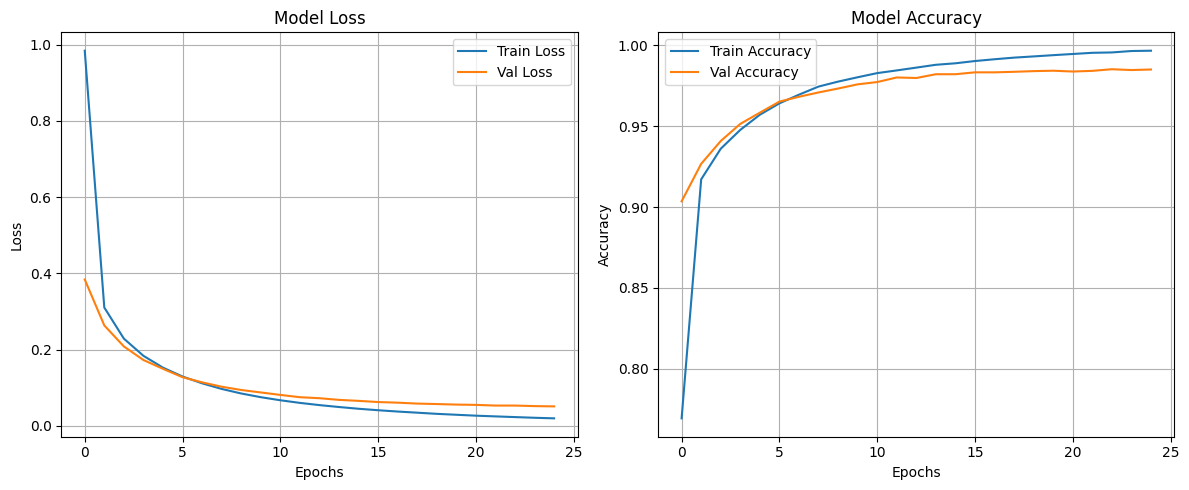

In [10]:
# Plotting loss and accuracies
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Val Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(train_accs, label='Train Accuracy')
axs[1].plot(val_accs, label='Val Accuracy')
axs[1].set_title('Model Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Collect predictions and true labels
lenet_5.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = lenet_5(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

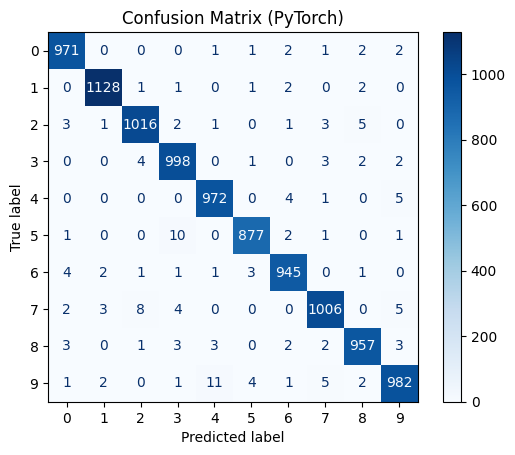

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Count of each label: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Total number of unique labels: 10


In [12]:
# Computing confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Displaying confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (PyTorch)")
plt.grid(False)
plt.show()

# Count unique labels in test dataset
test_labels = np.array([label for _, label in test_dataset])
unique_labels, counts = np.unique(test_labels, return_counts=True)

print(f"Unique labels: {unique_labels}")
print(f"Count of each label: {counts}")
print(f"Total number of unique labels: {len(unique_labels)}")

## <b>Making Prediction</b>

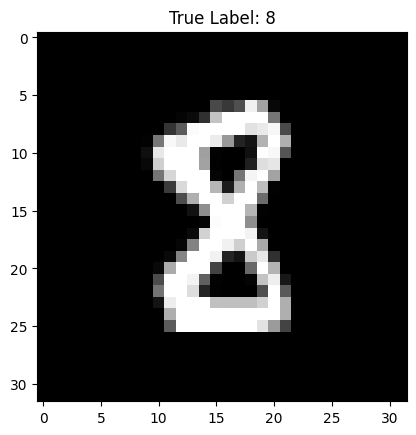

In [13]:
# Making Prediction
lenet_5.eval()
sample_img, label = test_dataset[179]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f'True Label: {label}')
plt.show()

In [14]:
with torch.no_grad():
    sample_img = sample_img.unsqueeze(0).to(device)
    output = lenet_5(sample_img)
    prob = torch.nn.functional.softmax(output, dim=1)
    print(f"Softmax Probabilites: {prob.cpu().numpy()}")
    print(f"Predicted Digit: {torch.argmax(prob).item()}")

Softmax Probabilites: [[1.10637975e-05 2.78211737e-05 1.67864142e-03 8.33976083e-04
  6.54691121e-06 1.17113141e-05 5.12407532e-05 2.24256519e-06
  9.96829808e-01 5.46944502e-04]]
Predicted Digit: 8


In [15]:
# Saving the model
torch.save(lenet_5.state_dict(), 'models/lenet5_mnist.pth')

<hr>